<a href="https://colab.research.google.com/github/rajuzumaki2207/Brain_tumour_detection_Segmentation/blob/main/Brain_MRI_Detection_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About data 
*This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in data.csv file.* 

Download link: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation



## LGG Segmentation Dataset

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in `data.csv` file.


All images are provided in `.tif` format with 3 channels per image.
For 101 cases, 3 sequences are available, i.e. pre-contrast, FLAIR, post-contrast (in this order of channels).
For 9 cases, post-contrast sequence is missing and for 6 cases, pre-contrast sequence is missing.
Missing sequences are replaced with FLAIR sequence to make all images 3-channel.
Masks are binary, 1-channel images.
They segment FLAIR abnormality present in the FLAIR sequence (available for all cases).


The dataset is organized into 110 folders named after case ID that contains information about source institution.
Each folder contains MR images with the following naming convention:

`TCGA_<institution-code>_<patient-id>_<slice-number>.tif`

Corresponding masks have a `_mask` suffix.

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
plt.style.use("ggplot")

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras.models import load_model
from skimage import io

In [4]:
path = "C:\\Users\\temp\\ML\\Projects\\Mask_RCNN_Brain_MRIs\\archive\\lgg-mri-segmentation\\kaggle_3m"



data = pd.read_csv(path + "/data.csv")

data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

## Data Pre-processing

In [6]:
import glob

data_map= []

for sub_dir in glob.glob(path + "/*"): # List all subdirectories
    try:
        dir_name =sub_dir.split('/')[-1]
        for file_name in os.listdir(sub_dir):
            image_path = sub_dir + '/' + file_name
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print (e)      

[WinError 267] The directory name is invalid: 'C:\\Users\\temp\\ML\\Projects\\Mask_RCNN_Brain_MRIs\\archive\\lgg-mri-segmentation\\kaggle_3m\\data.csv'
[WinError 267] The directory name is invalid: 'C:\\Users\\temp\\ML\\Projects\\Mask_RCNN_Brain_MRIs\\archive\\lgg-mri-segmentation\\kaggle_3m\\README.md'


In [7]:

img_path_df = pd.DataFrame({'patient_ID': data_map[::2] ,
                'path': data_map[1::2] })
img_path_df.head(5)

,patient_ID,path
0,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
1,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
2,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
3,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
4,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...


In [8]:
img_path_df[~img_path_df['path'].str.contains("mask")]

,patient_ID,path
0,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
1,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
3,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
5,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
7,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
...,...,...
7847,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
7849,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
7851,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
7853,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...


In [9]:
df_imgs= img_path_df[~img_path_df['path'].str.contains("mask")] ## dataframe only for brain images

In [10]:
df_mask= img_path_df[img_path_df['path'].str.contains("mask")] ## dataframe only for mask images


In [13]:
##stt="/content/drive/MyDrive/ML/Projects/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_"
st = "C:\\Users\\temp\\ML\\Projects\\Mask_RCNN_Brain_MRIs\\archive\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_"
xx=len(st)


In [14]:
BASE_LEN = xx # "C:\\Users\\temp\\ML\\Projects\\Mask_RCNN_Brain_MRIs\\archive\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_"
END_IMG_LEN = 4 # 
END_MASK_LEN = 9 # 

In [15]:
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_mask["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [16]:
import random
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs\archive\lgg-mri-segmentation\kaggle_3m\TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_5.tif 
Path to the Mask: C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs\archive\lgg-mri-segmentation\kaggle_3m\TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_5_mask.tif


In [17]:
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_ID.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
brain_df.head()

,patient_id,image_path,mask_path
0,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
1,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
2,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
3,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
4,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...


In [18]:
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path)) ## Return if mask tif has some values
    if value > 0 : 
        return 1
    else:
        return 0

In [19]:
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))


### 2 . Visualization

In [20]:
brain_df['mask'].value_counts() ## show how many mask [1] and no mask [0] we have

0    2556
1    1373
Name: mask, dtype: int64

Text(0.5, 1.0, 'Mask Count')

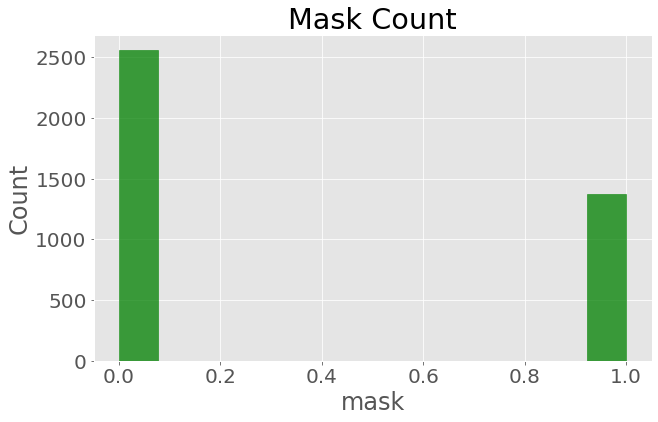

In [21]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
sns.histplot(data=brain_df, x= brain_df['mask'], element="step",  color= 'g')
plt.title('Mask Count')

444

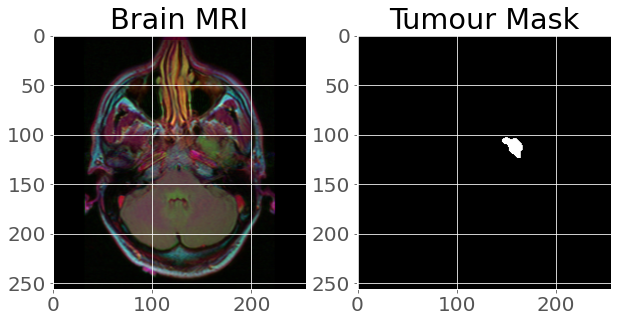

In [ ]:
i=0
while i < len(imgs): ## Show one MRI image along with its Mask
    if brain_df['mask'][i]==1:

        img_2_show =brain_df.image_path[i]
        mask_2_show = brain_df.mask_path[i]
        
        break # Break otherwise i will get updated and we only need one image
    else:
        i+=1
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(img_2_show))
plt.title("Brain MRI")
plt.subplot(1,2,2)
plt.imshow(cv2.imread(mask_2_show))
plt.title("Tumour Mask")
i

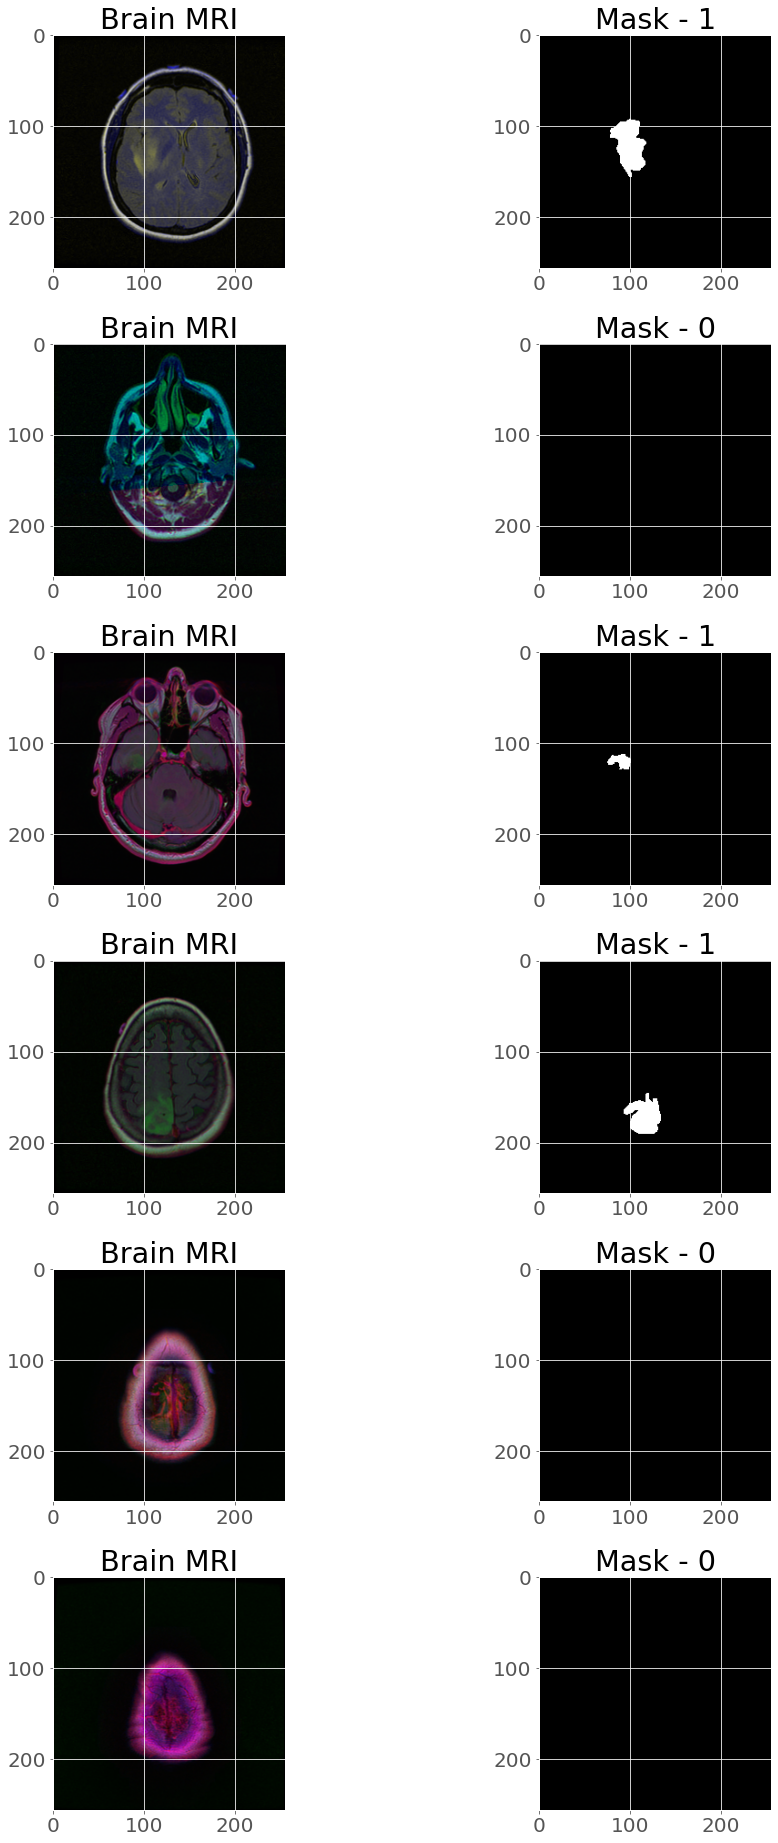

In [ ]:
fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

Text(0.5, 1.0, 'Mask')

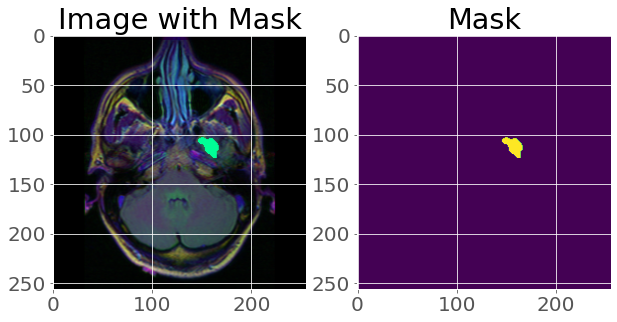

In [ ]:
## Overlap mask with the Image (I took the i value from the previous code block)
img = io.imread(brain_df.image_path[444])
msk = io.imread(brain_df.mask_path[444])
img[msk==255]=(0,255,150)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Image with Mask')
plt.subplot(1,2,2)
plt.imshow(msk)
plt.title('Mask')


### 3. Test Train Split 

In [28]:
brain_df_train = brain_df.drop(columns=['patient_id'])

In [29]:
from sklearn.model_selection import train_test_split
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [30]:
train, test = train_test_split(brain_df_train, test_size=0.15)

In [31]:
train

,image_path,mask_path,mask
3496,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,1
1870,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,1
1944,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,1
1513,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,1
690,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,0
...,...,...,...
2798,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,0
239,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,0
1305,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,0
2850,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,1


 (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#used-in-the-notebooks_1)

In [32]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)


In [33]:
## Train and Validation 

train_generator= datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset='training',
    class_mode='categorical',
    batch_size=16,
   
    shuffle=True,
    target_size=(256,256)
)
valid_generator = datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset='validation',
    class_mode='categorical',
    batch_size=16,
 
    shuffle=True,
    target_size=(256,256)
)

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.


In [34]:
# Test

test_datagen =  ImageDataGenerator(
    rescale=1./255,
)
test_generator = datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col='image_path',
    y_col='mask',
    class_mode='categorical',
    batch_size=1,
    
    shuffle=False,
    target_size=(256,256)
)

Found 590 validated image filenames belonging to 2 classes.


### Classification model to determine whether Tumour exists or not
#### I am going to use RESNET 50 as my base model

In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in basemodel.layers:
  layers.trainable = False
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)
model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

his_res50 = model.fit(
    train_generator, 
    steps_per_epoch= train_generator.n // 16,
    epochs = 15, validation_data= valid_generator, 
    validation_steps= valid_generator.n // 16, 
    callbacks=[checkpointer, earlystopping])

Epoch 1/15
187/187 [==============================] - ETA: 0s - loss: 0.7769 - accuracy: 0.6967
Epoch 1: val_loss improved from inf to 0.76814, saving model to classifier-resnet-weights.hdf5
187/187 [==============================] - 709s 4s/step - loss: 0.7769 - accuracy: 0.6967 - val_loss: 0.7681 - val_accuracy: 0.6156
Epoch 2/15
187/187 [==============================] - ETA: 0s - loss: 0.4736 - accuracy: 0.7552
Epoch 2: val_loss did not improve from 0.76814
187/187 [==============================] - 84s 451ms/step - loss: 0.4736 - accuracy: 0.7552 - val_loss: 21.1264 - val_accuracy: 0.3938
Epoch 3/15
187/187 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8080
Epoch 3: val_loss did not improve from 0.76814
187/187 [==============================] - 85s 452ms/step - loss: 0.4179 - accuracy: 0.8080 - val_loss: 0.8647 - val_accuracy: 0.6250
Epoch 4/15
187/187 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8087
Epoch 4: val_loss improved

In [ ]:
his_res50.history['val_loss'][1]=his_res50.history['val_loss'][0] 

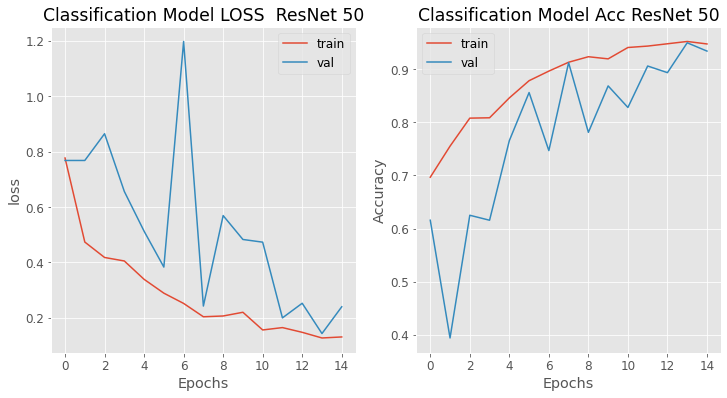

In [ ]:
plt.rcParams.update({'font.size':12})
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(his_res50.history['loss']);
plt.plot(his_res50.history['val_loss']);
plt.title("Classification Model LOSS  ResNet 50");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(his_res50.history['accuracy']);
plt.plot(his_res50.history['val_accuracy']);
plt.title("Classification Model Acc ResNet 50");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

### fitting the trained Model

In [ ]:
_, acc = model.evaluate(test_generator)
print("Test accuracy ResNet50 : {} %".format(acc*100))

590/590 [==============================] - 149s 252ms/step - loss: 0.2037 - accuracy: 0.9492
Test accuracy ResNet50 : 94.91525292396545 %


**I tried VGG as well, you can cross verify on the other Notebook. ResNET being a larger Network and also with bottleneck and skip arcgitecture is performing well compared to VGG16 model where test accuracy was around ~ 83%. I had to use collab because my local system was not able to train the resNET**

## Cross verify if HDF5 is usable

In [43]:
from keras.models import load_model
model= load_model(r'C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs\archive\from_colab\classifier-resnet-weights.hdf5', compile=True)

In [44]:
_, acc = model.evaluate(test_generator)
print("Test accuracy ResNet50 using HDF5: {} %".format(acc*100))

590/590 [==============================] - 15s 25ms/step - loss: 0.0748 - accuracy: 0.9814
Test accuracy ResNet50 using HDF5: 98.13559055328369 %


## Assess the trained Model

In [36]:
prediction = model.predict(test_generator)
pred = np.argmax(prediction, axis=1)

In [ ]:
Actual = np.asarray(test['mask']).astype('int')

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(Actual, pred)
print(accuracy)

0.9491525423728814


In [ ]:
cm = confusion_matrix(Actual, pred)
report = classification_report(Actual, pred, labels = [0,1])
print (report)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       388
           1       0.98      0.87      0.92       202

    accuracy                           0.95       590
   macro avg       0.96      0.93      0.94       590
weighted avg       0.95      0.95      0.95       590



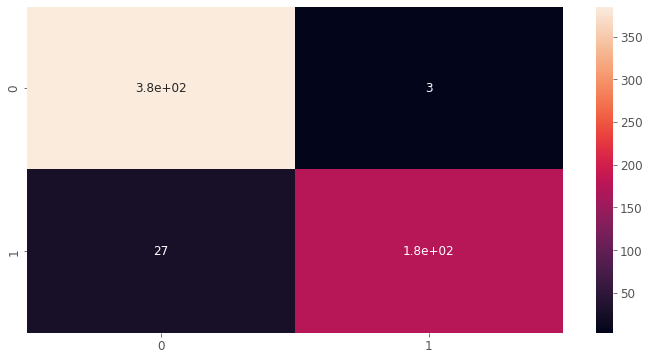

In [ ]:
plt.rcParams.update({'font.size':12})
plt.figure(figsize=(12,6))

sns.heatmap(cm, annot=True)

In [ ]:
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
    json_file.write(model_json)

## <font color='red'> Segmentation for Tumour

### <font color='blue'> Creating a custom datagenerator
https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

In [48]:
class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, list_IDs, 
               masks,image_dir = ' ', 
               batch_size=16, 
               img_w=256, img_h=256,
               shuffle=True):
    # 'Initialization'
    self.img_w = img_w
    self.img_h = img_h
    self.batch_size = batch_size
    self.list_IDs = list_IDs
    self.masks = masks
    self.image_dir= image_dir
    self.shuffle = shuffle
    self.on_epoch_end()
  def on_epoch_end(self):
  #'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  def __len__(self):
    #'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))
  def __getitem__(self, index):
    #'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    list_mask_temp = [self.masks[i] for i in indexes]
    # Generate data
    X, y = self.__data_generation(list_IDs_temp, list_mask_temp)

    return X, y
  def __data_generation(self, list_IDs_temp,list_mask_temp ):
    #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    

    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))
    for i in range(len(list_IDs_temp)):
      img_path = str(list_IDs_temp[i])
      mask_path =str(list_mask_temp[i])
      img = io.imread(img_path)
      mask= io.imread(mask_path)

      img= cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      mask = cv2.resize(mask, (self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()

      mask -= mask.mean()
      mask /= mask.std()

      X[i,] = img
      y[i,] = np.expand_dims(mask, axis = 2)

    #normalizing y
    y = (y > 0).astype(int)
    return X, y

      
  

In [49]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [51]:
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

Train size is 1167, valid size is 103 & test size is 103


In [52]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

In [53]:
val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

### Train and Val  Data generator 

In [54]:
train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

### Residual and Transpose conv blocks

In [51]:
def resblock(X, f):
  

    # make a copy of input
    X_copy = X

    # main path
    # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

    X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X) 

    X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)

    # Short path
    # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

    X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # Adding the output from main path and short path together

    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [52]:
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge

In [85]:
input_shape = (256,256,3)
X_input = Input(input_shape)

## Defining the segmention model using RESUNET backbone

In [54]:
# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [55]:
model_seg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Custom loss for segmentation ResUNET
https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

In [45]:
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [86]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Training the ResUNET

In [95]:
hist_seg =hist = model_seg.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/60
72/72 [==============================] - ETA: 0s - loss: 0.8146 - tversky: 0.2372
Epoch 1: val_loss improved from inf to 0.81640, saving model to ResUNet-segModel-weights.hdf5
72/72 [==============================] - 626s 8s/step - loss: 0.8146 - tversky: 0.2372 - val_loss: 0.8164 - val_tversky: 0.2366 - lr: 0.0500
Epoch 2/60
72/72 [==============================] - ETA: 0s - loss: 0.4900 - tversky: 0.6104
Epoch 2: val_loss improved from 0.81640 to 0.47330, saving model to ResUNet-segModel-weights.hdf5
72/72 [==============================] - 36s 506ms/step - loss: 0.4900 - tversky: 0.6104 - val_loss: 0.4733 - val_tversky: 0.6302 - lr: 0.0500
Epoch 3/60
72/72 [==============================] - ETA: 0s - loss: 0.3856 - tversky: 0.7173
Epoch 3: val_loss improved from 0.47330 to 0.45470, saving model to ResUNet-segModel-weights.hdf5
72/72 [==============================] - 29s 397ms/step - loss: 0.3856 - tversky: 0.7173 - val_loss: 0.4547 - val_tversky: 0.6477 - lr: 0.0500
Epoc

In [96]:
model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
    json_file.write(model_json)

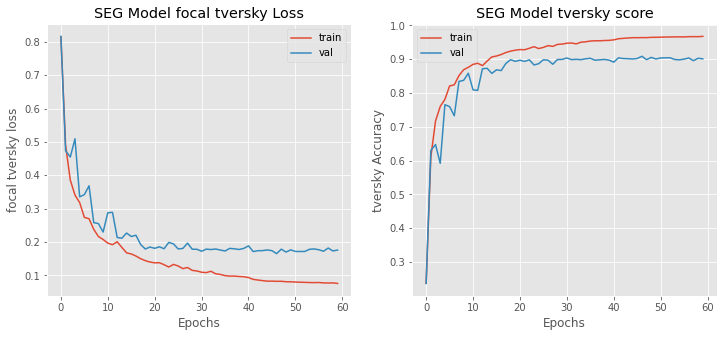

In [98]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist_seg.history['loss']);
plt.plot(hist_seg.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(hist_seg.history['tversky']);
plt.plot(hist_seg.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [100]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = model_seg.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 43s 9s/step - loss: 0.1568 - tversky: 0.9151
Segmentation tversky is 91.51%


In [59]:
def prediction(test, model, model_seg):
    '''
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
            continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

## Load the trained ResUNET (I trained the UNET in collab)

In [46]:
model_seg= load_model(r'C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs\archive\from_colab\ResUNet-segModel-weights.hdf5',custom_objects={'tversky': tversky,'focal_tversky': focal_tversky} )


In [55]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = model_seg.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 2s 93ms/step - loss: 0.0977 - tversky: 0.9550
Segmentation tversky is 95.50%


In [60]:
df_pred = prediction(test, model, model_seg)

In [61]:
df_pred

,image_path,predicted_mask,has_mask
0,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,No mask,0
1,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,No mask,0
2,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,No mask,0
3,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,"[[[[9.209109e-09], [5.51874e-07], [2.3557165e-...",1
4,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,No mask,0
...,...,...,...
585,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,No mask,0
586,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,"[[[[6.9638215e-09], [5.4608626e-07], [2.346841...",1
587,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,No mask,0
588,C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...,"[[[[1.1781505e-08], [2.532065e-07], [1.7712539...",1


In [64]:
df_pred = test.merge(df_pred, on= 'image_path')

In [67]:
df_pred.has_mask

0      0
1      0
2      0
3      1
4      0
      ..
585    0
586    1
587    0
588    1
589    0
Name: has_mask, Length: 590, dtype: int64

## Visualize the predicted tumour mask against actual tumour

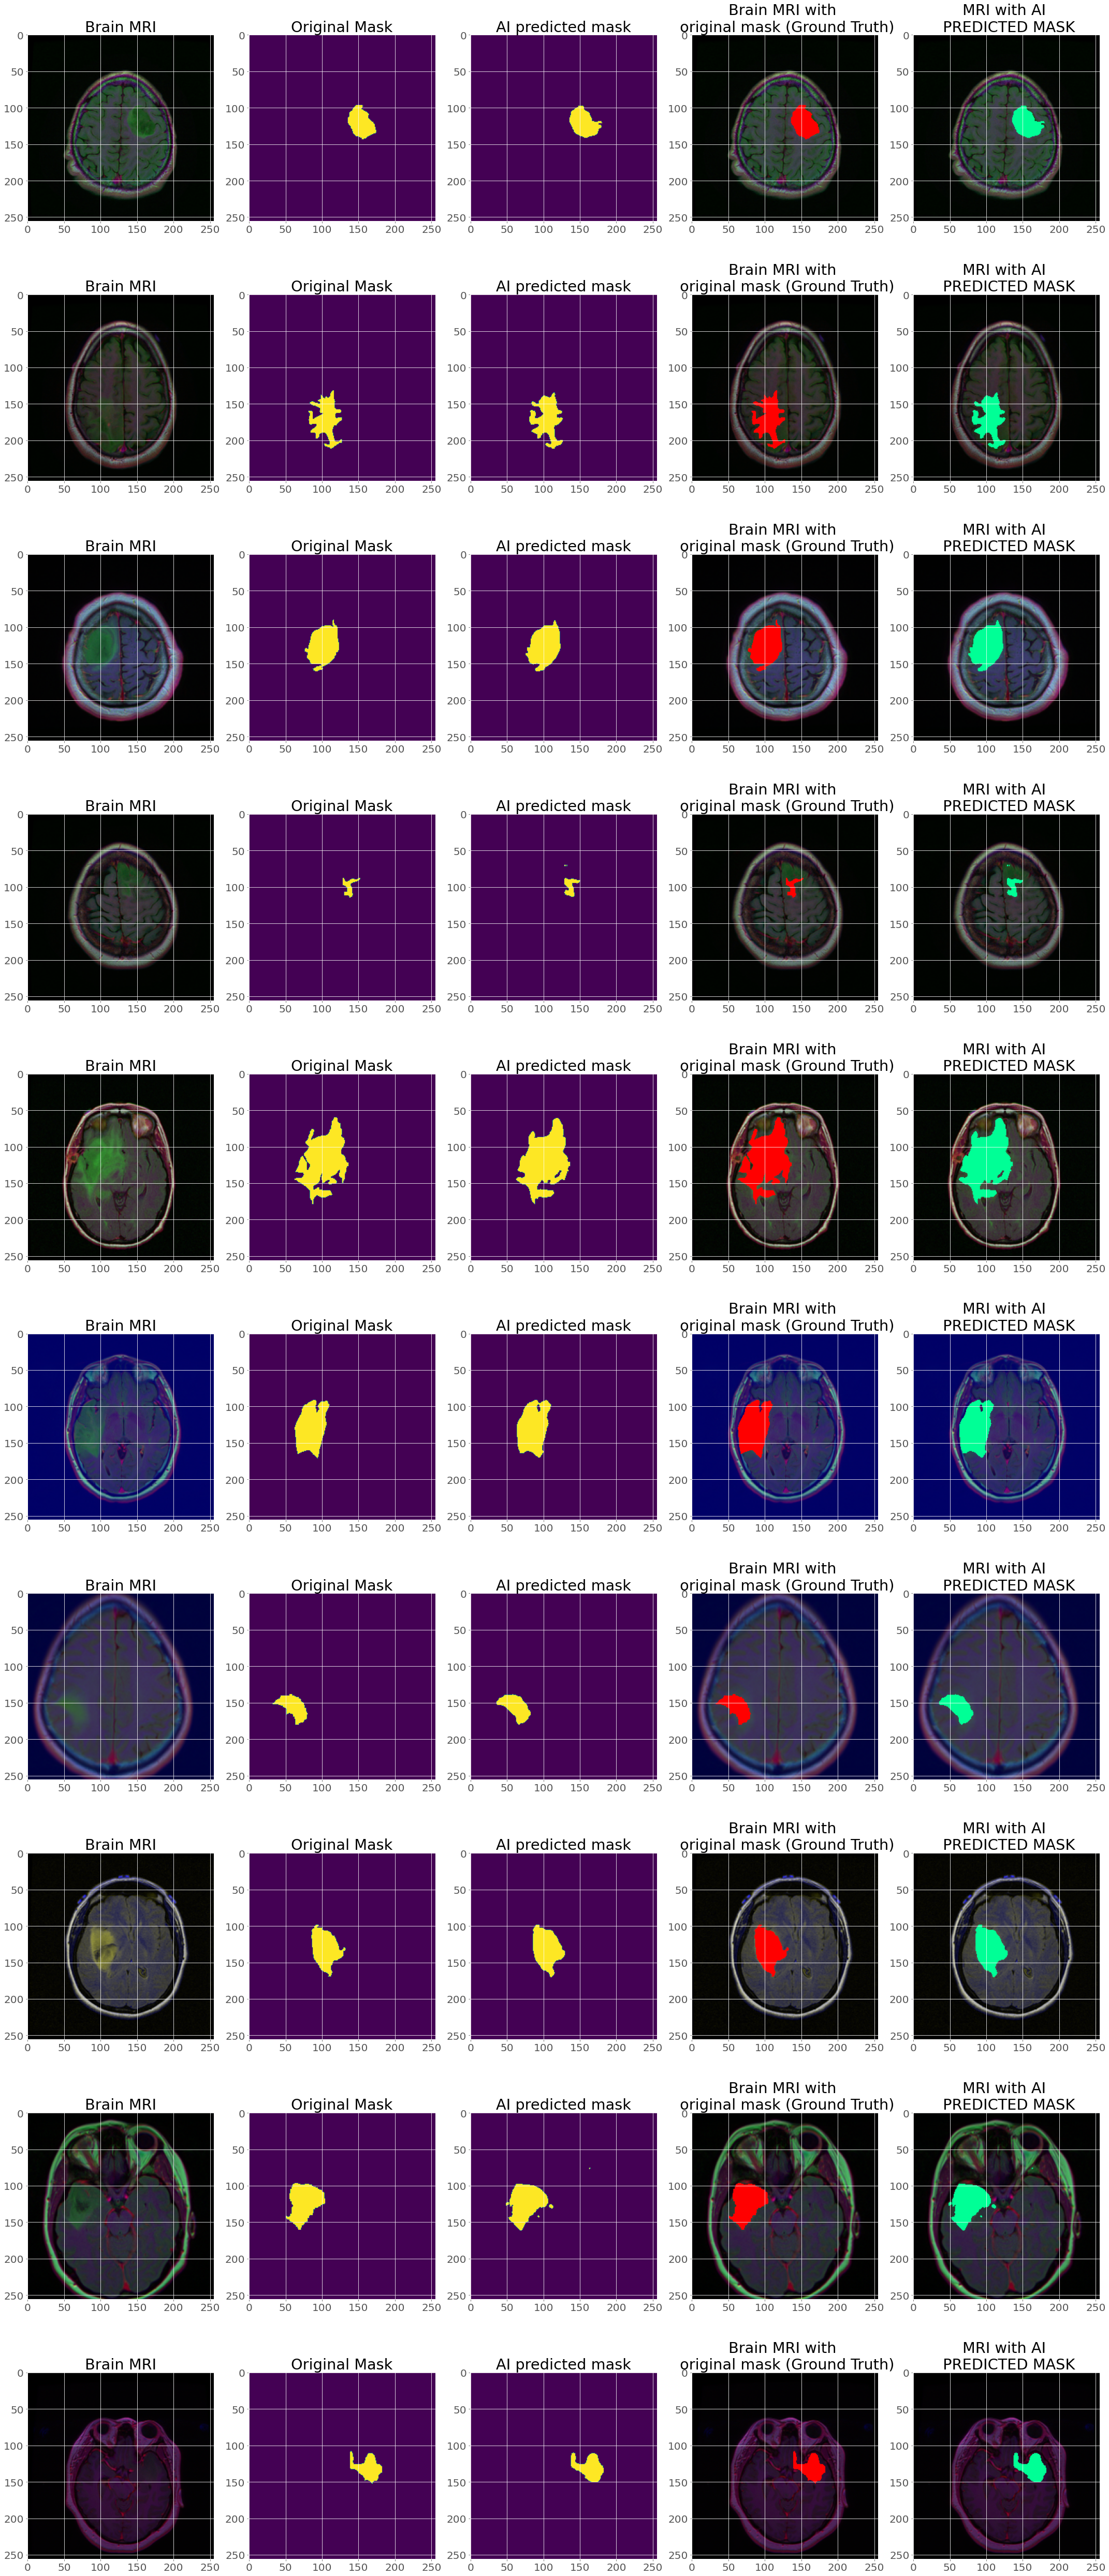

In [102]:
count = 0
fig, axs = plt.subplots(10,5, figsize=(30,70))
for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<10:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with \n original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI \n PREDICTED MASK')
        
        count +=1
    if (count==10):
        break

fig.tight_layout()